# Overview

**ARIMA** (AutoRegressive Integrated Moving Average) Model is a popular econometric model that combines prediction method of three time series analysis methods: AutoRegressive (**AR**), Integration, in terms of time series (**I**), and Moving Average (**MA**). 

Something about pdq
something about stationarity


## Objective
1. Explorer and engineer API output data
    - Rolling Mean/Moving Average
    - Candle stick plotly visualization
2. Perform series of tests on data to determine ARIMA order candidacy
    - Differencing
    - Autocorrelation and Partial Autocorrelation Function
    - Augmented Dickey-Fuller Test (Stationarity)
    - Visualize
3. Build a baseline model
    - Calculate error
    - Visualize performance
4. Build a class to automate objective 1-3


## Libraries Import

In [133]:
import pandas as pd
import numpy as np
import os
import statsmodels as sm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

from datetime import datetime, timedelta

import plotly.graph_objects as go
import plotly.express as px

import sys
sys.path.append('../')

import src.tda_api_tools as tda

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', category=UserWarning)

from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

%matplotlib inline

## Data Import

To start the EDA a downloaded dataset will be used. The data set is a collection of `S&P500` stock daily open, high, low, and close prices and volume data from 10/14 2015 to 12/17 2020. 

In [134]:
# Get daily closing price of SPY
symbol = "SPY"
file_path = "../data/{}_daily01.csv".format(symbol)
data_df = pd.read_csv(file_path, index_col="datetime")

#### Reset index to datetime index

Also preview the input dataframe

In [135]:
data_df.index = pd.DatetimeIndex(data_df.index)
type(data_df.index)
data_df.head()

,open,high,low,close,volume
datetime,,,,,
2015-10-14 01:00:00,200.18,200.87,198.9400,199.29,99106161
2015-10-15 01:00:00,200.08,202.36,199.6400,202.35,134142195
2015-10-16 01:00:00,202.83,203.29,201.9200,203.27,114580052
2015-10-19 01:00:00,202.50,203.37,202.1300,203.37,76523897
2015-10-20 01:00:00,202.85,203.84,202.5471,203.09,78448484


### Candle Stick Chart

In [ ]:
# USE PLOTLY

## Calculating Rolling Means on Closing Prices

Rolling mean (moving averages) is a very common way to analyzing time series data. By utilizing the inherent resistence of mean values more steady prediction can be made.To incorporate API data cleaning and automate the rolling mean calculation following can be performed. 

In [136]:
close_df = data_df.copy()
rolling_days = [10, 25, 50, 250]

for rolling in rolling_days:
    column = f"MA ({rolling})"
    close_df[column] = data_df.rolling(rolling).mean().close
    
close_df.drop(columns=["high", "low", "open", "volume"], inplace=True)
close_df.dropna(inplace=True)
close_df.head()

,close,MA (10),MA (25),MA (50),MA (250)
datetime,,,,,
2016-10-10 01:00:00,216.16,215.626,215.500832,216.688410,206.659139
2016-10-11 01:00:00,213.43,215.412,215.276800,216.618210,206.715699
2016-10-12 01:00:00,213.71,215.119,215.064800,216.581426,206.761139
2016-10-13 01:00:00,213.01,214.952,214.844800,216.518026,206.800099
2016-10-14 01:00:00,213.12,214.634,214.838400,216.452232,206.839099


Building the operation above as a function to build the library. 

In [137]:
def moving_averages(input_df, days_list:list, col:str):
    out_ma_columns = [col] #intial lize output column list with input column
    for day in days_list:
        column = f"MA({day})"
        input_df[column] = input_df.rolling(day).mean()[col] #make rolling/moving averages
        out_ma_columns.append(column) #build output column list
    
    return input_df[out_ma_columns].dropna() #output df with no errors

In [138]:
eda_df = moving_averages(data_df, [50, 250], "close")
eda_df.head()

,close,MA(50),MA(250)
datetime,,,
2016-10-10 01:00:00,216.16,216.688410,206.659139
2016-10-11 01:00:00,213.43,216.618210,206.715699
2016-10-12 01:00:00,213.71,216.581426,206.761139
2016-10-13 01:00:00,213.01,216.518026,206.800099
2016-10-14 01:00:00,213.12,216.452232,206.839099


### Processed API Data Visualization

Visualization of closing prices and moving averages clearly demonstrate that they are not stationary. All show upward trend over entirity of the data. Large moving averages show more linear trend, which is to be expected.

In [139]:
fig = go.Figure() #initialize plotly figure

for col in eda_df.columns: # for columns in the dataframe
    fig.add_trace(go.Scatter(y=eda_df[col], x=eda_df.index, name=col)) # add trace of data

#prettify
fig.layout.title.text = "{} Closing and Moving Average Prices".format(symbol)    
fig.show()

Covert above to a function

## ARIMA Order Calculation

To prepare the ARIMA model for forecasting on our data few parameters must be caluclated and analyzed. First and foremost, the input data must be stationary for **AR** and **MA** models. The stationarity can be checked with Augmented Dickey-Fuller test.  Then, autocorrelation and partial autocorrelation functions (ACF andACF) can be utilized to calculated the **AR** and **MA** orders.

### Stationarity

For data to be stationary it must have constant
- time dependent mean
- time dependent variance
- time depedent covariance

#### Integration(Differencing)
Integration or differencing with different lag orders can be used to motify the input data and potentially remove trend and seasonality. The orders of lag required to achieve stationary determines (d) or **I** of ARIMA model. 

#### Augmented Dickey-Fuller Test
Performing Augmented Dickey-Fuller (ADF) test can be used to determined if the data is stationary. The more negative number returned by this test, the stronger rejection of null hypothesis (presence of unit root). 



### Autocorrelation (ACF) and Partial Autocorrelation (PACF)
These functions can be used to determine the level of significance each lag has on its future data set. By determining at what order these test stop being significance either AR or MA order can be established depending on the test. If no clearly order can be derived from these functions a gridsearch (permutative interation) can be used to determined best ARIMA model. 


### Augmented Dickey-Fuller Test (ADF) for Stationarity

In [140]:
# ADF

def adf_test(timeseries:pd.Series, lags="AIC", alpha=0.05):
    dftest = adfuller(timeseries, autolag=lags) #adf_result of this time series
    dfoutput = pd.Series([timeseries.name], index=["series name"]) #get inputname
    dfoutput = pd.concat([dfoutput, pd.Series(dftest[0:4], index=["Test Statistic", 
                                                                  "p-value", 
                                                                  "#Lags Used", 
                                                                  "Number of Observations Used"])]) #get adf result values
    
    #================Reject Null Hypothesis based on p-value and alpha==========================#
    # data has potential to be stationary if this is true
    if dfoutput["p-value"] <= alpha:
        dfoutput["reject null hypothesis"] = True
    else:
        dfoutput["reject null hypothesis"] = False
    
    
    
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value #add critical value
        
    return dfoutput

#### Stationarity check for current data

None of the current data are stationary and are not good candidate for AR or MA based models. 

In [160]:
for col in eda_df.columns:
    print(f"Checking Stationary on {col}")
    test_result = adf_test(eda_df[col])
    print(test_result)
    print("Data is Stationary") if test_result["reject null hypothesis"] else print("Data is NOT stationary") #stationary confirmation output
    print("=============================")
    print("\n") #formatting

Checking Stationary on close
series name                       close
Test Statistic                 -1.16424
p-value                        0.688788
#Lags Used                            9
Number of Observations Used        1045
reject null hypothesis            False
Critical Value (1%)            -3.43662
Critical Value (5%)            -2.86431
Critical Value (10%)           -2.56824
dtype: object
Data is NOT stationary
Checking Stationary on MA(50)
series name                      MA(50)
Test Statistic                -0.803155
p-value                        0.818193
#Lags Used                           10
Number of Observations Used        1044
reject null hypothesis            False
Critical Value (1%)            -3.43663
Critical Value (5%)            -2.86431
Critical Value (10%)           -2.56825
dtype: object
Data is NOT stationary
Checking Stationary on MA(250)
series name                     MA(250)
Test Statistic                -0.812923
p-value                        0.815

### Differencing and Integration for testing stationarity in lags.

The order of I ("d") can be calculated by checking for data stationairty at given order of lag. For example a data set with stationarity at lag difference of 2 indicate ARIMA model with `d = 2` as a good predictor.  

In [142]:
#creating differences

test_df = eda_df.copy()
for col in test_df:
    column = "{}_lag_diff".format(col)
    test_df[column] = test_df[col].diff()
test_df.dropna(inplace=True) #drops first diff column    
test_df.head()

,close,MA(50),MA(250),close_lag_diff,MA(50)_lag_diff,MA(250)_lag_diff
datetime,,,,,,
2016-10-11 01:00:00,213.43,216.618210,206.715699,-2.73,-0.070200,0.05656
2016-10-12 01:00:00,213.71,216.581426,206.761139,0.28,-0.036784,0.04544
2016-10-13 01:00:00,213.01,216.518026,206.800099,-0.70,-0.063400,0.03896
2016-10-14 01:00:00,213.12,216.452232,206.839099,0.11,-0.065794,0.03900
2016-10-17 01:00:00,212.38,216.336232,206.876259,-0.74,-0.116000,0.03716


In [161]:
def differences (input_df, lags=1):
    input_columns = input_df.columns
    
    # for all lags
    for i in range(1, lags+1):
        for col in input_columns:
            col_name = "{}_lag_{}".format(col, i)
            input_df[col_name] = input_df[col].diff(i)

    return input_df.dropna()

Build to function

In [162]:
eda_df = differences(eda_df, lags=1)

### Difference data stationarity check



In [163]:
for col in eda_df.columns:
    print(f"Checking Stationary on {col}")
    test_result = adf_test(eda_df[col])
    print(test_result)
    print("Data is Stationary") if test_result["reject null hypothesis"] else _ #stationary confirmation output
    print("=============================")

Checking Stationary on close
series name                       close
Test Statistic                 -1.19118
p-value                        0.677378
#Lags Used                            9
Number of Observations Used        1043
reject null hypothesis            False
Critical Value (1%)            -3.43664
Critical Value (5%)            -2.86432
Critical Value (10%)           -2.56825
dtype: object
Checking Stationary on MA(50)
series name                      MA(50)
Test Statistic                -0.815403
p-value                        0.814556
#Lags Used                           10
Number of Observations Used        1042
reject null hypothesis            False
Critical Value (1%)            -3.43664
Critical Value (5%)            -2.86432
Critical Value (10%)           -2.56825
dtype: object
Checking Stationary on MA(250)
series name                     MA(250)
Test Statistic                -0.724194
p-value                        0.840383
#Lags Used                           18
Nu

### Visualization and Data Stationarity - Part 2.

Visualization of lag 1 difference results shows more stationarity than the original data. `Dickey-Fuller` test result of lag 1 data also show more stationarity. 

In [148]:
fig = go.Figure()

for col in eda_df.columns[3:]:
    fig.add_trace(go.Scatter(y=eda_df[col], x=eda_df.index, name=col))
    
fig.layout.title.text = "{}Closing and Moving Average with lag1".format(symbol)     
fig.show()

### ACF and PACF 

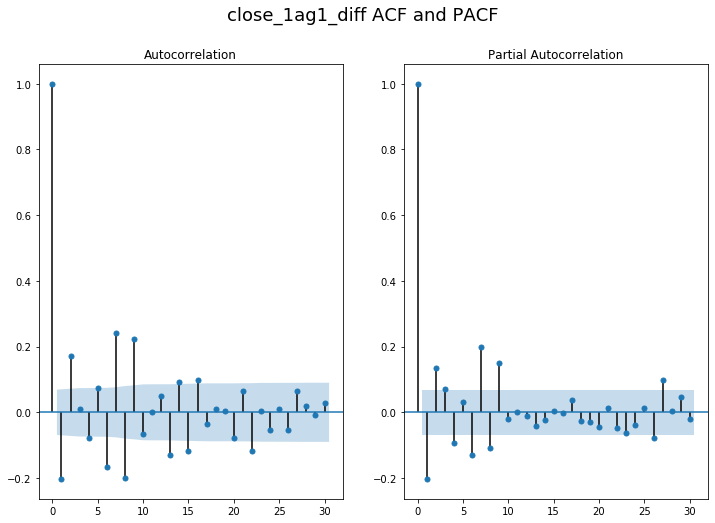

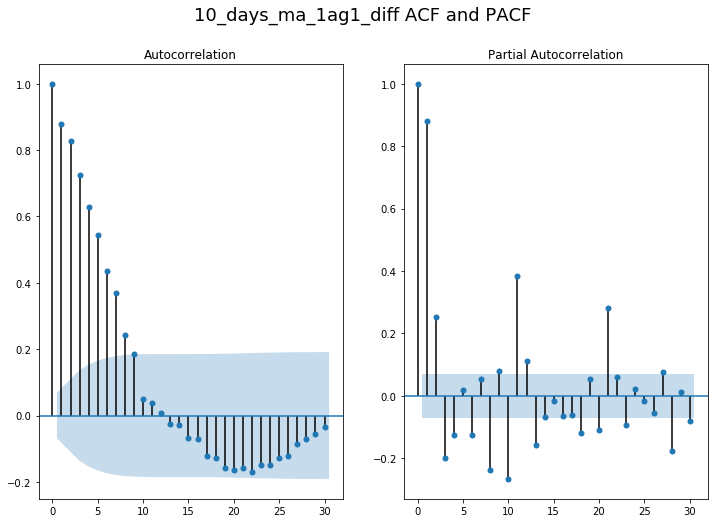

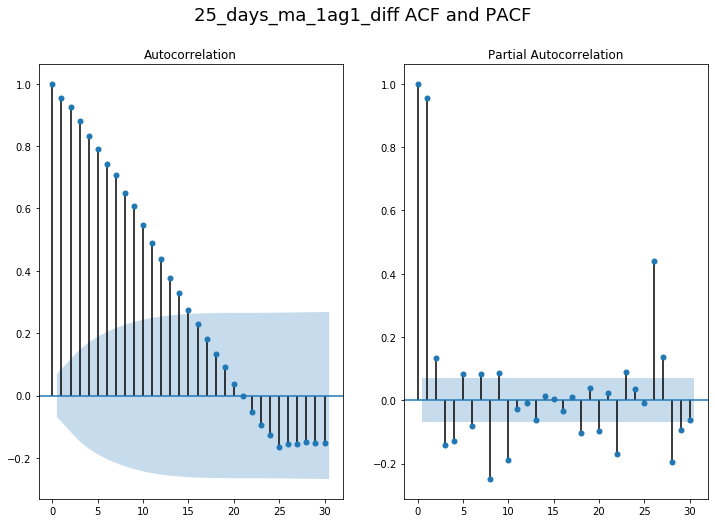

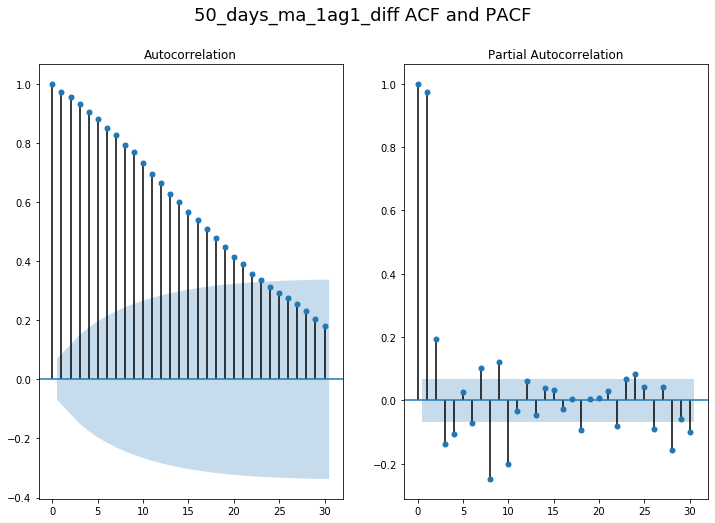

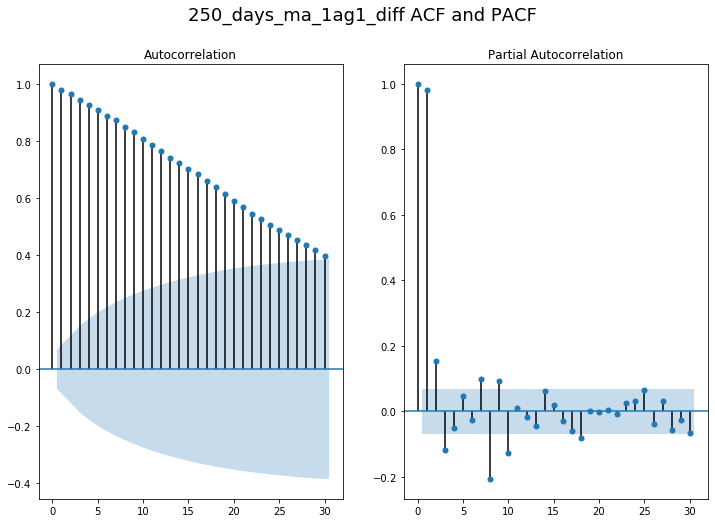

In [632]:
for col in stationary_data:
    plot_title = "{} ACF and PACF".format(col)
    fig, ax = plt.subplots(1,2, figsize=(12,8))
    plot_acf(close_df[col].values, ax=ax[0], alpha=0.05);
    plot_pacf(close_df[col], ax=ax[1], alpha=0.05);
    fig.suptitle(plot_title, size=18)

In [633]:
for col in stationary_data:
    pacf_results = pacf(close_df[col], alpha=0.05, nlags=20)
    print(pacf_results)
    #============= Patrial Autocorrelation=============#
    for idx, value in enumerate(pacf_results[0]):
        checkval = sorted(pacf_results[1][idx])
        if value > checkval[0] and value < checkval[1]: # if the value is within the confidence interval
            ar_val = idx+1
            break
    print("AR values for {}: ".format(col), ar_val)    
    print("======================================")

(array([ 1.00000000e+00, -2.03287986e-01,  1.35279108e-01,  7.19178399e-02,
       -9.45484223e-02,  3.15266133e-02, -1.30499540e-01,  1.99865415e-01,
       -1.08159636e-01,  1.51123057e-01, -2.02219263e-02,  5.42793369e-05,
       -1.25057758e-02, -4.06243984e-02, -2.32081331e-02,  4.40458669e-03,
       -3.19207932e-03,  3.76310830e-02, -2.66263850e-02, -2.83602881e-02,
       -4.34833127e-02]), array([[ 1.        ,  1.        ],
       [-0.27236764, -0.13420833],
       [ 0.06619945,  0.20435876],
       [ 0.00283819,  0.14099749],
       [-0.16362808, -0.02546877],
       [-0.03755304,  0.10060627],
       [-0.19957919, -0.06141989],
       [ 0.13078576,  0.26894507],
       [-0.17723929, -0.03907998],
       [ 0.0820434 ,  0.22020271],
       [-0.08930158,  0.04885773],
       [-0.06902537,  0.06913393],
       [-0.08158543,  0.05657388],
       [-0.10970405,  0.02845526],
       [-0.09228779,  0.04587152],
       [-0.06467507,  0.07348424],
       [-0.07227173,  0.06588757],
   

In [629]:
for col in stationary_data:
    acf_results = acf(close_df[col], alpha=0.05, nlags=20, fft=True, qstat=True)
    
    #=======Auto Correlation=========================#
    for idx, value in enumerate(acf_results[0]):
        heckval = sorted(acf_results[1][idx])
        if value > checkval[0] and value < checkval[1]: # if the value is within the confidence interval
            ma_val = idx+1
            break
      
    print("MA values for {}: ".format(col), ma_val)
    print("======================================")

MA values for close_1ag1_diff:  1
MA values for 10_days_ma_1ag1_diff:  1
MA values for 25_days_ma_1ag1_diff:  1
MA values for 50_days_ma_1ag1_diff:  1
MA values for 250_days_ma_1ag1_diff:  1


In [637]:
acf_results[3]

array([2.15711028e-170, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000])

In [640]:
2/np.sqrt(len(acf_results[0]))

0.4364357804719848

In [642]:
2/np.sqrt(8)

0.7071067811865475

In [645]:
np.exp(2*1.96/np.sqrt(8-3)-1)/np.exp(2*1.96/np.sqrt(8-3)+1)



0.1353352832366127

In [643]:
np.exp(2*1.96/np.sqrt(21-3)-1)/np.exp(2*1.96/np.sqrt(21-3)+1)

0.1353352832366127

In [154]:
test_series = eda_df["MA(50)_lag_1"]
acf(test_series, alpha=0.05, qstat=True)

(array([ 1.        ,  0.97214723,  0.95519134,  0.92964932,  0.90245183,
         0.87739341,  0.84789394,  0.8259562 ,  0.78986042,  0.76572441,
         0.7283252 ,  0.69340277,  0.66191833,  0.62488925,  0.596105  ,
         0.56293008,  0.53614495,  0.5046214 ,  0.47375166,  0.44430111,
         0.41203066,  0.38700659,  0.35505767,  0.33166554,  0.31004998,
         0.29030353,  0.27013992,  0.25064875,  0.22911526,  0.20281238,
         0.17843731,  0.14959998,  0.12469767,  0.09993207,  0.07520441,
         0.05335643,  0.02784058,  0.0011041 , -0.02840549, -0.05675578,
        -0.08746454]),
 array([[ 1.00000000e+00,  1.00000000e+00],
        [ 9.11804930e-01,  1.03248953e+00],
        [ 8.52606932e-01,  1.05777574e+00],
        [ 7.98622839e-01,  1.06067581e+00],
        [ 7.49279612e-01,  1.05562404e+00],
        [ 7.05950588e-01,  1.04883624e+00],
        [ 6.60814371e-01,  1.03497350e+00],
        [ 6.25371435e-01,  1.02654096e+00],
        [ 5.77252056e-01,  1.00246879e+00

In [157]:
1.96/(np.sqrt(len(eda_df.close)))

0.060343409037093766

In [159]:
test_series = eda_df["MA(50)_lag_1"]
pacf(test_series, alpha=0.05)

C:\Users\Yung\Anaconda3\envs\fitsnbits\lib\site-packages\statsmodels\tsa\stattools.py:1021: FutureWarning:

The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs // 2 - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.



(array([ 1.        ,  0.97306957,  0.19085457, -0.1351028 , -0.10322986,
         0.0260217 , -0.06841353,  0.10029544, -0.2374919 ,  0.11548374,
        -0.19103344, -0.03440403,  0.05589761, -0.04759582,  0.03959729,
         0.02795385, -0.02084892,  0.00292136, -0.08596616,  0.00589935,
         0.00199475,  0.02908824, -0.07655468,  0.06269445,  0.07902737,
         0.03697442, -0.08459084,  0.0437361 , -0.14219813, -0.05693092,
        -0.09140493, -0.06207226,  0.02190773, -0.01193144, -0.03734236,
         0.08247981, -0.10677783, -0.06351341, -0.03835621, -0.03137832,
        -0.06100923]),
 array([[ 1.00000000e+00,  1.00000000e+00],
        [ 9.12727271e-01,  1.03341187e+00],
        [ 1.30512271e-01,  2.51196872e-01],
        [-1.95445105e-01, -7.47605047e-02],
        [-1.63572162e-01, -4.28875617e-02],
        [-3.43205958e-02,  8.63640047e-02],
        [-1.28755827e-01, -8.07122659e-03],
        [ 3.99531383e-02,  1.60637739e-01],
        [-2.97834197e-01, -1.77149597e-01

## Combine process for ARIMA order calculation



In [565]:
def find_ARIMA_d(data_df, alpha=0.05, diff_lim=2):
    stationary_data = []
    for d in range(1, diff_lim+1):
        for column in data_df:
            print("Calculating ADF on {}".format(column))
            test_result = adf_test(data_df[column])
            print(test_result)
            if test_result["p-value"] < alpha:
                stationary_data.append(column)
            print("=======================================")
        if len(stationary_data) == 0:
            for col in data_df:
                column = "{}_1ag{}_diff".format(col, d)
                data_df[column] = data_df[col].diff()
            data_df.dropna(inplace=True) #drops first diff column 
        elif len(stationary_data) > 0:
            break

    print("Following data is stationary: ")
    print(stationary_data)
    print("Calculated to I order of ", d)
    return data_df, stationary_data, d

In [566]:
def find_ARIMA_p_d_q(data_df, alpha=0.05, d_lim=2):
    data_df, st_list, d = find_ARIMA_d(data_df, alpha=alpha, diff_lim=d_lim)
    arima_order=[]
    for col in st_list:
        acf_results = acf(data_df[col], alpha=alpha, nlags=20, fft=True)
        pacf_results = pacf(data_df[col], alpha=alpha, nlags=20)

        #=======Auto Correlation=========================#
        for idx, value in enumerate(acf_results[0]):
            checkval = sorted(acf_results[1][idx])
            if value >= checkval[0] and value < checkval[1]: # if the value is within the confidence interval
                ma_val = idx+1
                break

        #============= Patrial Autocorrelation=============#
        for idx, value in enumerate(pacf_results[0]):
            checkval = sorted(pacf_results[1][idx])
            if value >= checkval[0] and value < checkval[1]: # if the value is within the confidence interval
                ar_val = idx+1
                break
        print("AR values for {}: ".format(col), ar_val)    
        print("MA values for {}: ".format(col), ma_val)
        arima_order.append((ar_val, d, ma_val))
        print("======================================")
    arima_columns = dict(zip([st_col.split("_")[0] for st_col in st_list], arima_order))
    return data_df, arima_columns

In [567]:
out_df, model_orders = find_ARIMA_p_d_q(close_df[:50], d_lim=d)

Calculating ADF on close
Results of Dickey-Fuller Test:
Test Statistic                  0.474637
p-value                         0.984081
#Lags Used                      1.000000
Number of Observations Used    48.000000
Critical Value (1%)            -3.574589
Critical Value (5%)            -2.923954
Critical Value (10%)           -2.600039
dtype: float64
Calculating ADF on 10_days_ma
Results of Dickey-Fuller Test:
Test Statistic                  2.123707
p-value                         0.998814
#Lags Used                     11.000000
Number of Observations Used    38.000000
Critical Value (1%)            -3.615509
Critical Value (5%)            -2.941262
Critical Value (10%)           -2.609200
dtype: float64
Calculating ADF on 25_days_ma
Results of Dickey-Fuller Test:
Test Statistic                  0.931574
p-value                         0.993489
#Lags Used                      1.000000
Number of Observations Used    48.000000
Critical Value (1%)            -3.574589
Critical Valu

/Users/yunghanjeong/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning:

invalid value encountered in sqrt



In [568]:
model_orders

{'close': (2, 1, 2), '250': (2, 1, 2)}

In [295]:
close_df.head()

,close,10_days_ma,25_days_ma,50_days_ma,250_days_ma,500_days_ma,close_1ag1_diff,10_days_ma_1ag1_diff,25_days_ma_1ag1_diff,50_days_ma_1ag1_diff,250_days_ma_1ag1_diff,500_days_ma_1ag1_diff
datetime,,,,,,,,,,,,
2017-10-09 01:00:00,253.95,252.203,250.1864,247.9764,235.253757,220.984728,-0.42,0.502,0.2444,0.1408,0.16208,0.10932
2017-10-10 01:00:00,254.62,252.757,250.5288,248.1334,235.417397,221.089268,0.67,0.554,0.3424,0.1570,0.16364,0.10454
2017-10-11 01:00:00,255.02,253.254,250.8536,248.2874,235.585437,221.192768,0.40,0.497,0.3248,0.1540,0.16804,0.10350
2017-10-12 01:00:00,254.64,253.683,251.1644,248.4314,235.751517,221.295308,-0.38,0.429,0.3108,0.1440,0.16608,0.10254
2017-10-13 01:00:00,254.95,254.055,251.4992,248.5912,235.921797,221.399028,0.31,0.372,0.3348,0.1598,0.17028,0.10372


In [576]:
true_df = close_df[:70]

In [577]:
true_index = true_df[-prediction_length:].index

In [580]:
prediction_length = 25
model_data = true_df.close[:-prediction_length]

In [581]:
model = ARIMA(model_data, order=(2,1,2)) #fit and predictarima_model = model.fit()
arima_model = model.fit()
model_prediction = arima_model.forecast(steps=prediction_length)

In [582]:
model_prediction_idx = [(model_data.index[-1] + timedelta(days=i)) for i in range (1, len(model_prediction)+1)]
model_prediction.index = true_index

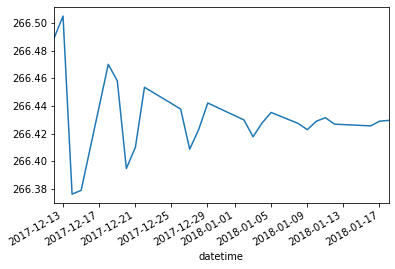

In [583]:
model_prediction.plot()

In [596]:
model.

AttributeError: 'ARIMA' object has no attribute 'values'

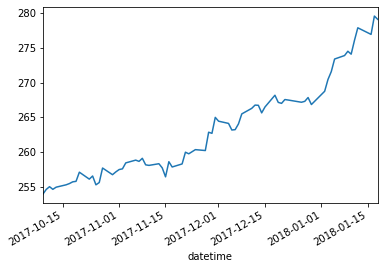

In [584]:
true_df.close.plot()

In [585]:
plot_df = pd.concat([true_df, model_prediction], axis=1)

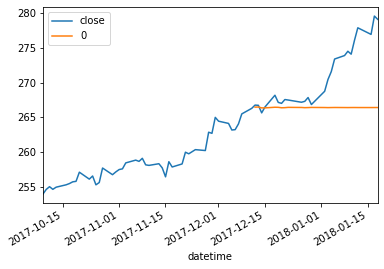

In [589]:
plot_df[["close", 0]].plot()

In [597]:
#plot ARIMA model with plotly

true = close_df.close #true
model = arima_model.fittedvalues[1:] #drop first fitted value since it's 0

fig = go.Figure()

fig.add_trace(go.Scatter(y=true_df.values, x=true_df.index, name="SPY")) #true
fig.add_trace(go.Scatter(y=model.values, x=model.index, name="Model")) #model
fig.add_trace(go.Scatter(y=model_prediction.values, x=model_prediction.index, name="Prediction")) #model


fig.layout.title.text = "{} Price with ARIMA 2, 1, 2".format(symbol)     
fig.show()

In [263]:
model_rmse = np.sqrt(mean_squared_error(true[1:], model))
print("Model RMSE", model_rmse)
model_percent_rmse = model_rmse/true[1:].mean()
print("Model %RMSE", model_percent_rmse)

Model RMSE 3.7854786134535616
Model %RMSE 0.01295176075578542


## Autocorrelation and Partial Autocorrelation 

All Partial Autocorrelation (PACF) of listed stock and indeces below showed significant drop in correlation at lag 2. This shows that AR(2) is an appropriate start for modeling selected companies. 

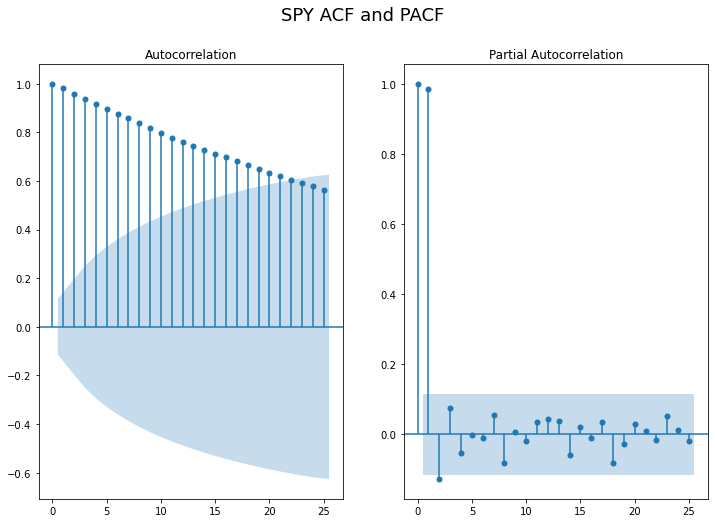

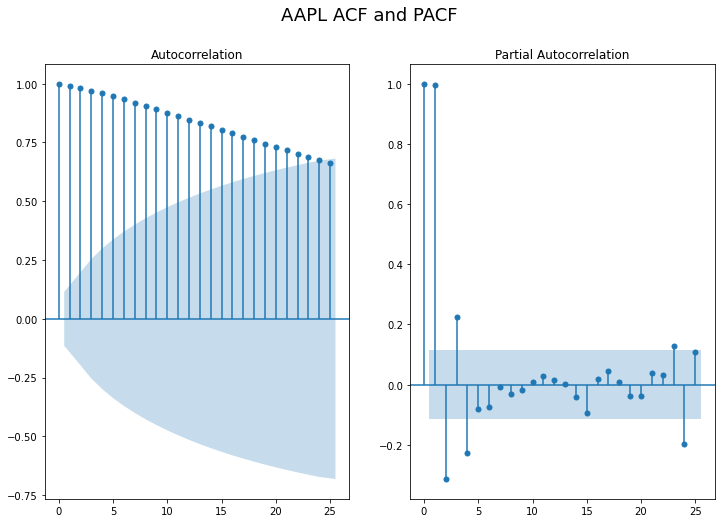

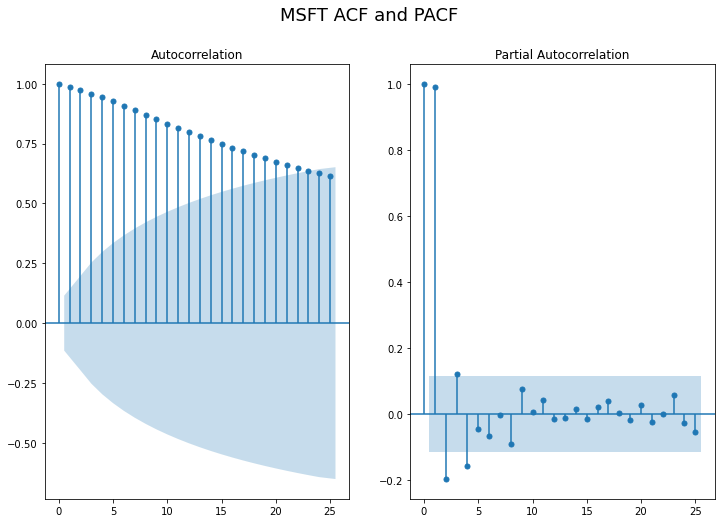

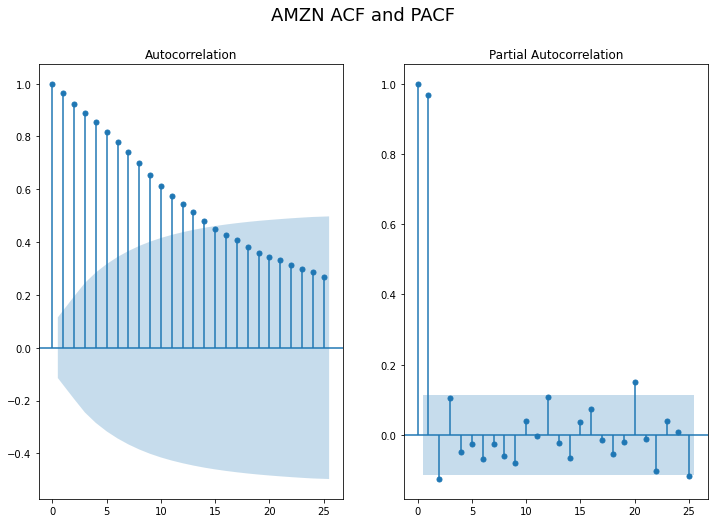

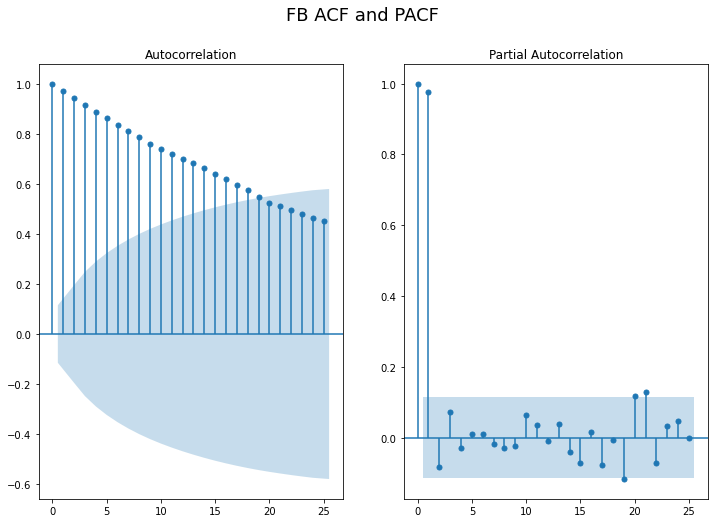

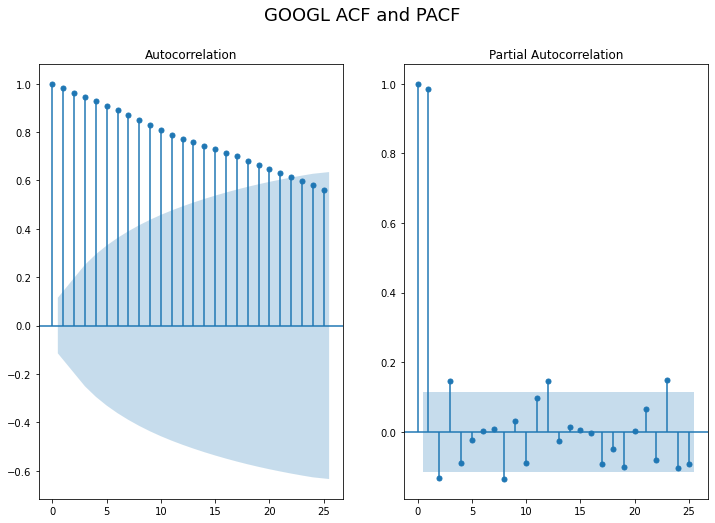

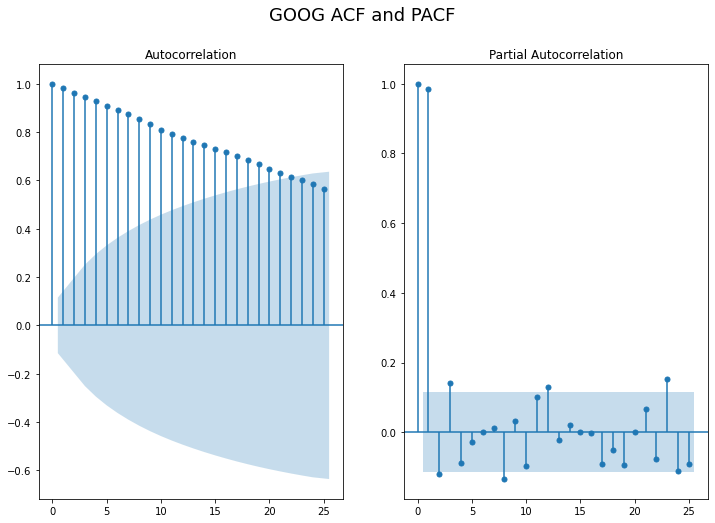

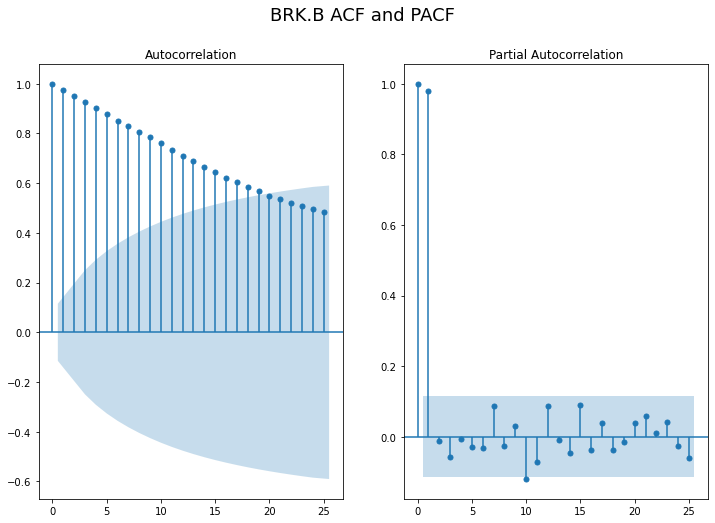

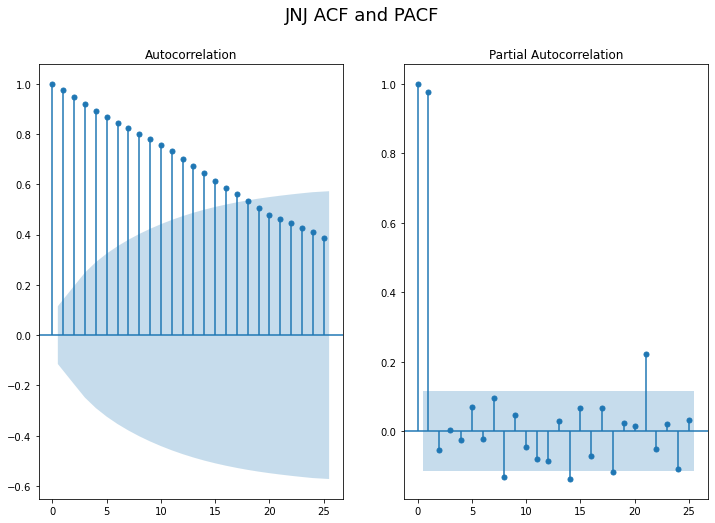

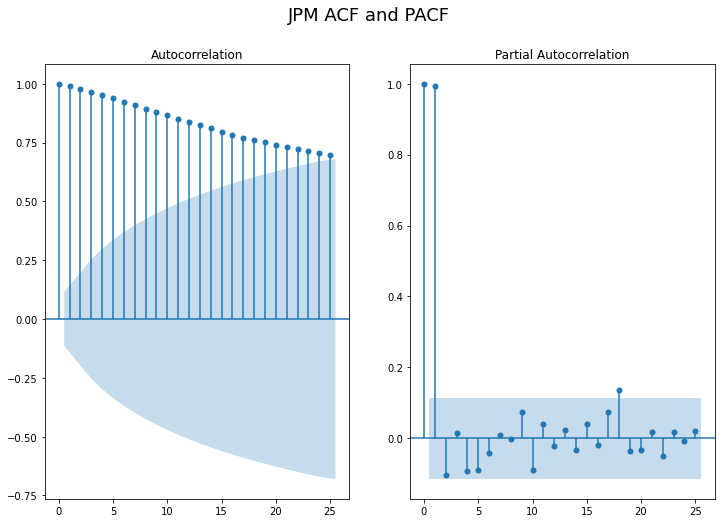

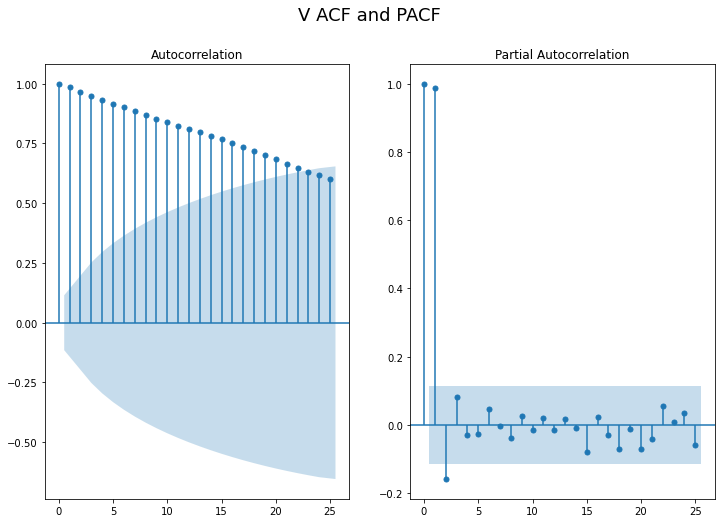

In [47]:
for symbol in symbols:
    filepath = "../data/{}_daily01.csv".format(symbol)
    stock_df = pd.read_csv(filepath)
    stock_df = stock_df[(stock_df.to_datetime > analysis_date_start) & (stock_df.to_datetime < analysis_date_end)]["close"]
    plot_title = "{} ACF and PACF".format(symbol)
    fig, ax = plt.subplots(1,2, figsize=(12,8))
    plot_acf(close_df.values, ax=ax[0]);
    plot_pacf(stock_df.values, ax=ax[1]);
    fig.suptitle(plot_title, size=18)
    plt.savefig("../images/{}.acf_pacf.png".format(symbol))